In [ ]:
%run main.py -c configs/one_batch.json

In [1]:
from pathlib import Path
import argparse
import json
import wandb

import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import DataLoader, Subset, random_split
import torch

from tts.collate_fn import LJSpeechCollator
from tts.spectrogram import MelSpectrogram
from tts.datasets import LJSpeechDataset
from tts.models import FastSpeech
from tts.loss import FastSpeechMSELoss
from tts.aligner import GraphemeAligner
from tts.vocoders import WaveGlow
from tts.trainer import *
from tts.utils import *

In [2]:
with open("configs/one_batch.json") as file:
    config = json.load(file)

In [10]:
if config["logger"]["use_wandb"]:
    wandb.init(project=config["logger"]["wandb_project_name"])

seed_everything(config)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if config["main"]["verbose"]:
    print(f"The training process will be performed on {device}.")

if config["main"]["verbose"]:
    print("Downloading and splitting the data.")

dataset = LJSpeechDataset(config["data"]["path_to_data"])
train_size = int(config["trainer"]["train_ratio"] * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(
    dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(config["main"]["seed"])
)

train_dataset = Subset(train_dataset, np.arange(config["trainer"]["batch_size"])) \
    if config["main"]["overfit"] is True else train_dataset

train_dataloader = DataLoader(
    train_dataset, 
    collate_fn=LJSpeechCollator(),
    batch_size=config["trainer"]["batch_size"], 
    num_workers=config["main"]["num_workers"]
)

val_dataloader = DataLoader(
    val_dataset,
    collate_fn=LJSpeechCollator(),
    batch_size=config["trainer"]["batch_size"],
    num_workers=config["main"]["num_workers"]
)

if config["main"]["verbose"]:
    print("Initializing the vocoder, aligner, melspectrogramer, model, optimizer and lr_scheduler.")

vocoder = WaveGlow().eval().to(device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: khaykingleb (use `wandb login --relogin` to force relogin)


The training process will be performed on cpu.
Initializing the vocoder, aligner, melspectrogramer, model, optimizer and lr_scheduler.


In [11]:
aligner = GraphemeAligner(config).to(device)
melspectrogramer = MelSpectrogram(config).to(device)

model = FastSpeech(config).to(device)
criterion = FastSpeechMSELoss()

In [12]:
trainable_params = filter(lambda param: param.requires_grad, model.parameters())
optimizer = init_obj(config["optimizer"], torch.optim, trainable_params)
lr_scheduler = init_obj(config["lr_scheduler"], torch.optim.lr_scheduler, optimizer)

if config["pretrained_model"]["load_model"]:
    if config["main"]["verbose"]:
        print("Downloading the pretrained model.")
    checkpoint = torch.load(config["pretrained_model"]["checkpoint_path"])
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optim_state_dict"])

if config["logger"]["use_wandb"]:
    wandb.watch(model)

In [13]:
train(
    config=config, 
    model=model, 
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    criterion=criterion,
    vocoder=vocoder,
    aligner=aligner,
    melspectrogramer=melspectrogramer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device
)

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
import matplotlib.pyplot as plt

In [9]:
for batch in train_dataloader:
    break

In [10]:
import sys
sys.path.append('waveglow/')

import torch.nn as nn


In [11]:
class Vocoder(nn.Module):

    def __init__(self):
        super(Vocoder, self).__init__()

        model = torch.load('waveglow_256channels_universal_v5.pt', map_location='cpu')[
            'model']
        self.net = model.remove_weightnorm(model)

    @torch.no_grad()
    def inference(self, spect: torch.Tensor):
        spect = self.net.upsample(spect)

        # trim the conv artifacts
        time_cutoff = self.net.upsample.kernel_size[0] - \
            self.net.upsample.stride[0]
        spect = spect[:, :, :-time_cutoff]

        spect = spect.unfold(2, self.net.n_group, self.net.n_group) \
            .permute(0, 2, 1, 3) \
            .contiguous() \
            .flatten(start_dim=2) \
            .transpose(-1, -2)

        # generate prior
        audio = torch.randn(spect.size(0), self.net.n_remaining_channels, spect.size(-1)) \
            .to(spect.device)

        for k in reversed(range(self.net.n_flows)):
            n_half = int(audio.size(1) / 2)
            audio_0 = audio[:, :n_half, :]
            audio_1 = audio[:, n_half:, :]

            output = self.net.WN[k]((audio_0, spect))

            s = output[:, n_half:, :]
            b = output[:, :n_half, :]
            audio_1 = (audio_1 - b) / torch.exp(s)
            audio = torch.cat([audio_0, audio_1], 1)

            audio = self.net.convinv[k](audio, reverse=True)

            if k % self.net.n_early_every == 0 and k > 0:
                z = torch.randn(
                    spect.size(0), self.net.n_early_size, spect.size(2),
                    device=spect.device
                )
                audio = torch.cat((z, audio), 1)

        audio = audio.permute(0, 2, 1) \
            .contiguous() \
            .view(audio.size(0), -1)

        return audio

In [12]:
vocoder = Vocoder().eval()

In [ ]:
reconstructed_wav = vocoder.inference(mels).cpu()


NameError: name 'mels' is not defined

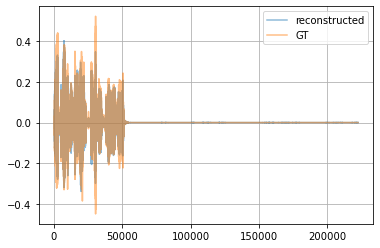

In [ ]:
plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.plot(waveform.squeeze(), label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [ ]:
from IPython import display

display.display(display.Audio(reconstructed_wav, rate=22050))
display.display(display.Audio(waveform, rate=22050))

In [13]:
import math
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

In [14]:
class DurationPredictor(nn.Module):
    
    def __init__(self, hidden_size: int, kernel_size: int, dropout: float):
        super().__init__()

        self.duration_predictor = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_size,
                out_channels=hidden_size,
                kernel_size=kernel_size,
                padding="same"
            ),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(
                in_channels=hidden_size,
                out_channels=hidden_size,
                kernel_size=kernel_size,
                padding="same"
            ),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Params:
            x: tensor with shape of (batch_size, seq_len, embed_size)

        Returns: 
            out: tensor with shape of (batch_size, seq_len)
        """

        for idx, operation in enumerate(self.duration_predictor):
            if idx == 0 or idx == 4:
                x = operation(x.permute(0, 2, 1)).permute(0, 2, 1)
            else:
                x = operation(x)

        durations = x.squeeze(-1)

        return durations 

In [15]:
from typing import Tuple
import torch
import torch.nn as nn

In [103]:
class Attention(nn.Module):
    def __init__(self, hidden_size: int, num_heads: int, dropout: float):
        super().__init__()
        attention_size = hidden_size // num_heads

        self.W_Q = nn.Linear(hidden_size, attention_size)
        self.W_K = nn.Linear(hidden_size, attention_size)
        self.W_V = nn.Linear(hidden_size, attention_size)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Params:
            query: tensor with shape of (batch_size, seq_len, hidden_size)
            key: tensor with shape of (batch_size, seq_len, hidden_size)
            value: tensor with shape of (batch_size, seq_len, hidden_size)
            mask: tensor with shape of (batch_size, seq_len) ???
        
        Returns: 
            out: tensor with shape of (batch_size, seq_len, hidden_size // 2)
        """
        Q, K, V = self.W_Q(x), self.W_K(x), self.W_V(x)

        attention = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(Q.shape[-1])
        
        scores = F.softmax(attention, dim=-1)
        out = torch.bmm(scores, V)
        out = self.dropout(out)

        return out
        

class MultiHeadAttention(nn.Module):
    """
    Based on https://arxiv.org/pdf/1706.03762.pdf
    """

    def __init__(self, hidden_size: int, num_heads: int, dropout: float):
        super().__init__()

        self.multi_head = nn.Sequential(
            *[Attention(hidden_size, num_heads, dropout) for _ in range(num_heads)]
        )
        
        self.linear = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Params:
            x: tensor with shape of (batch_size, seq_len, hidden_size) 

        Returns:
            out: tensor with shape of (batch_size, seq_len, hidden_size) 
        """
        heads_out = torch.cat([attention(x) for attention in self.multi_head], dim=-1)
        out = self.linear(heads_out)

        return out


class FFTBlock(nn.Module):

    def __init__(
            self, 
            hidden_size: int, 
            num_heads: int, 
            dropout: float,
            kernel_size: int
        ):
        super().__init__()
        
        self.multi_head_attention = MultiHeadAttention(hidden_size, num_heads, dropout)
        
        self.conv = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_size,
                out_channels=hidden_size,
                kernel_size=kernel_size,
                padding="same"
            ),
            nn.ReLU(),
            nn.Conv1d(
                in_channels=hidden_size,
                out_channels=hidden_size,
                kernel_size=kernel_size,
                padding="same"
            )
        )

        self.layer_norm_1 = nn.LayerNorm(hidden_size)
        self.layer_norm_2 = nn.LayerNorm(hidden_size)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Params:
            x: tensor of shape (batch_size, seq_len, emded_size)

        Returns:
            
        """
        out = self.multi_head_attention(self.layer_norm_1(x)) + x
        out = self.conv(self.layer_norm_2(out).permute(0, 2, 1)).permute(0, 2, 1) + out

        return out
        

class PositionalEncoding(nn.Module):
    """
    Got from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, embed_size: int, max_len: int, dropout: float):
        super().__init__()
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2) * (-np.log(10000.0) / embed_size))
        positional_encoding = torch.zeros(max_len, 1, embed_size)
        positional_encoding[:, 0, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('positional_encoding', positional_encoding)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Params:
            x: tensor of shape (batch_size, seq_len, emded_size)

        Returns:
            out: tensor of shape (batch_size, seq_len, emded_size)
        """
        out = x + self.positional_encoding[:x.size(0)]
        out = self.dropout(out)

        return out


class FastSpeech(nn.Module):
    def __init__(
            self,
            arch_config=None,
            vocab_size=51,
            n_mels=80,
            phoneme_fft_blocks: int = 6,
            melspec_fft_blocks: int = 6,
            phoneme_embed_size: int = 384,
            num_heads: int = 2,
            hidden_size: int = 384,
            dropout: float = 0.1,
            kernel_size: int = 3,
            phoneme_max_len: int = 5000
        ):
        super().__init__()

        self.phoneme_embedding = nn.Embedding(vocab_size, phoneme_embed_size)
        self.positional_encoding = PositionalEncoding(phoneme_embed_size, phoneme_max_len, dropout)
        self.encoder = nn.Sequential(
            *[FFTBlock(hidden_size, num_heads, dropout, kernel_size) for _ in range(phoneme_fft_blocks)]
        )
        self.duration_predictor = DurationPredictor(hidden_size, kernel_size, dropout)

        self.decoder = nn.Sequential(
            *[FFTBlock(hidden_size, num_heads, dropout, kernel_size) for _ in range(melspec_fft_blocks)]
        )
        self.linear = nn.Linear(hidden_size, n_mels)


    def length_regulator(self, x: torch.Tensor, durations: torch.Tensor, alpha: float = 1.0) -> torch.Tensor:
        """
        Params:
            x: tensor with shape of (batch_size, seq_len, embed_size)
            durations: tensor with shape of (batch_size, seq_len)
            alpha: paramter that makes speech slower or faster

        Returns: 
            x_extended: tensor with shape of (batch_size, seq_len_extended, embed_size)
        """
        # Prediction of durations is presented in logarithmic scale
        durations = torch.round(durations * alpha).int()

        x_extended = []

        for i in range(x.shape[0]):
            x_extended.append(x[i, :, :].repeat_interleave(durations[i, :], dim=0))

        x_extended = pad_sequence(x_extended).transpose(0, 1)

        return x_extended
        

    def forward(self, x: torch.Tensor, durations_teacher: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        Params: 
            x: tensor of shape (batch_size, seq_len)
            durations_teacher: tensor with shape of (batch_size, seq_len_teacher)

        Returns:
            durations_pred: tensor with shape of (batch_size, seq_len_student)
            melspec_pred: tensor with shape of (batch_size, n_mels, seq_len_teacher)
        """
        out = self.encoder(self.positional_encoding(self.phoneme_embedding(x)))
        durations_pred = self.duration_predictor(out)

        out = self.length_regulator(out, durations_teacher)
        out = self.decoder(self.positional_encoding(out))
        melspec_pred = self.linear(out).permute(0, 2, 1)

        return durations_pred, melspec_pred

    def inference(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        Params: 
            x: tensor of shape (batch_size, seq_len)

        Returns:
            melspec_pred: tensor with shape of (batch_size, n_mels, seq_len)
        """
        out = self.encoder(self.positional_encoding(self.phoneme_embedding(x)))
        durations_pred = self.duration_predictor(out)
        # Prediction of durations is presented in logarithmic scale
        durations_pred = torch.exp(durations_pred)

        out = self.length_regulator(out, durations_pred)
        out = self.decoder(self.positional_encoding(out))

        melspec_pred = self.linear(out).permute(0, 2, 1)

        return melspec_pred

In [104]:
vocab_size = 51
phoneme_embed_size =384

In [105]:
phoneme_embedding = nn.Embedding(
    num_embeddings=vocab_size, 
    embedding_dim=phoneme_embed_size
)

In [106]:
phoneme_max_len = 5000
phoneme_embed_size = 384
dropout_prob = 0.1

In [107]:
phoneme_embedding = nn.Embedding(vocab_size, phoneme_embed_size)
positional_encoding = PositionalEncoding(phoneme_embed_size, phoneme_max_len, dropout_prob)

In [108]:
x = batch.tokens

In [109]:
out = phoneme_embedding(x)

In [110]:
out = positional_encoding(out)

In [111]:
fft_block = FFTBlock(384, 2, 0.1, 3)

In [112]:
out = fft_block(out)

In [113]:
out.shape

torch.Size([16, 154, 384])

In [114]:
duration_predictor = DurationPredictor(384, 3, 0.1)

In [115]:
durations_student = duration_predictor(out)

In [116]:
f = FastSpeech()

In [117]:
out = f.length_regulator(out, durations_student)

RuntimeError: repeats can not be negative

In [ ]:
out.shape

torch.Size([16, 153, 384])

In [75]:
out

tensor([[[-2.1704e+00,  7.1880e-01,  9.5718e-01,  ...,  2.6958e+00,
           1.3482e+00,  7.7930e-01],
         [-6.2984e-01,  1.3160e+00, -1.8129e+00,  ...,  4.8639e+00,
           8.4367e-01, -2.2971e-01],
         [-5.7790e-01, -8.7910e-01,  1.1817e-01,  ...,  2.9360e+00,
          -6.1491e-01,  3.1297e+00],
         ...,
         [ 3.8984e-01, -1.0993e-01, -8.5827e-01,  ...,  2.1422e-01,
          -1.1606e+00,  1.4583e+00],
         [ 5.6111e-01, -4.9339e-01, -6.1888e-01,  ...,  8.9955e-02,
          -1.1579e+00,  1.4793e+00],
         [ 4.9671e-01, -1.3094e-01, -1.0279e+00,  ...,  1.6723e-01,
          -1.2078e+00, -9.4810e-02]],

        [[ 2.9621e+00,  2.5791e+00,  2.3808e-02,  ...,  2.6339e-02,
           1.1489e+00,  2.1816e+00],
         [-1.2048e+00,  2.5963e-01, -1.1981e-01,  ...,  2.2233e+00,
           6.9123e-01,  6.6138e-01],
         [ 5.6139e-01,  3.3742e-01, -9.4288e-01,  ...,  1.5536e+00,
          -9.4594e-02,  8.3712e-02],
         ...,
         [ 1.3905e+00, -6

In [76]:
decoder = nn.Sequential(
    *[FFTBlock(384, 2, 0.1, 1) for _ in range(6)]
)

In [77]:
out = decoder(out)

In [78]:
predictor = nn.Linear(384, 80)

In [79]:
out = predictor(out)

In [80]:
out.shape

torch.Size([16, 154, 80])

In [81]:
out = out.permute(0, 2, 1)

In [82]:
out.shape

torch.Size([16, 80, 154])

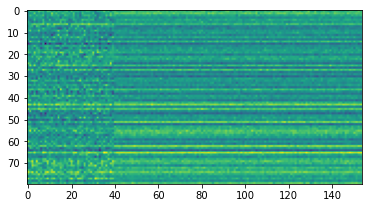

In [83]:
plt.imshow(out[0, :, :].detach().numpy())

In [118]:
vocoder = WaveGlow().eval()
aligner = GraphemeAligner(config)
model = FastSpeech()

In [119]:
melspectrogramer = melspectrogram(config).to(device)

In [120]:
class FastSpeechMSELoss(nn.MSELoss):
    def __init__(self):
        super().__init__()

        self.mse_loss = nn.MSELoss()

    def forward(self, durations_student, durations_teacher, melspec_pred, melspec_true) -> float:
        durations_loss = self.mse_loss(durations_student, durations_teacher)
        melspec_loss = self.mse_loss(melspec_pred, melspec_true)

        return durations_loss + melspec_loss

In [121]:
criterion = FastSpeechMSELoss()

In [122]:
def prepare_batch(
    batch, 
    melspectrogramer, 
    aligner, 
    device
):
    batch.melspec = melspectrogramer(batch.waveform.to(device))

    durations = aligner(batch.waveform, batch.waveform_length, batch.transcript)
    durations_melspec = []
    for index in range(batch.waveform.shape[0]):
        durations_wave = durations[index]
        durations_normalized = durations_wave / durations_wave.sum()
        melspec = melspectrogramer(batch.waveform[index][:batch.waveform_length[index]])
        durations_melspec.append(torch.round(durations_normalized * melspec.shape[1]).float())
        
    batch.durations = pad_sequence(durations_melspec).permute(1, 0)

    return batch.to(device)

In [138]:
def prolong_melspecs(
      melspec_pred: torch.Tensor, 
      melspec_true: torch.Tensor,
      config,
      device
) -> torch.Tensor:
    """
    Pad short spectrogramm with silence.
    """

    def prolong_short(
        short_melspec: torch.Tensor, 
        long_melspec: torch.Tensor,
        config,
        device
    ) -> torch.Tensor:

        fill_tensor = torch.ones((
            short_melspec.shape[0], 
            short_melspec.shape[1], 
            long_melspec.shape[2] - short_melspec.shape[2])
        ).to(device) * config["preprocessing"]["spectrogram"]["args"]["pad_value"]

        prolonged_melspec = torch.cat([short_melspec, fill_tensor], dim=2)

        return prolonged_melspec

    if melspec_pred.shape[2] <= melspec_true.shape[2]:
        melspec_pred = prolong_short(config, device, melspec_pred, melspec_true)    
    else:
        melspec_true = prolong_short(config, device, melspec_true, melspec_pred) 

    return melspec_pred, melspec_true

In [123]:
def validate_epoch(
    config, 
    model,
    criterion,
    vocoder,
    aligner,
    melspectrogramer,
    val_dataloader,
    device
):
    model.eval()

    val_loss = 0
    counter = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch = prepare_batch(batch, melspectrogramer, aligner, device)

            durations_pred, melspec_pred = model.inference(batch.tokens, batch.durations)
            melspec_pred, batch.melspec = prolong_melspecs(
                config, device, melspec_pred, batch.melspec
            )    
            
            loss = criterion(durations_pred, batch.durations, melspec_pred, batch.melspec)

            if config["logger"]["use_wandb"] and config["logger"]["log_frequency"] == 0:             
                wandb.log({"Validation loss": loss.item()})
            
            val_loss += loss.item()
            counter += 1

        if config["logger"]["use_wandb"]:

            wandb.log({
                "Predicted Spectrogram": wandb.Image(
                    melspec_pred[0, :, :].detach().cpu().numpy(), 
                    caption=batch.transcript[0].capitalize()
                ),
                "True Spectrogram": wandb.Image(
                    batch.melspec[0, :, :].detach().cpu().numpy(),
                    caption=batch.transcript[0].capitalize()
                )
            })

            wav_pred = vocoder.inference(melspec_pred).cpu().squeeze()
            wandb.log({
                "Predicted Audio": wandb.Audio(
                    wav_pred.detach().cpu().numpy(), 
                    sample_rate=config["preprocessing"]["sr"], 
                    caption=batch.transcript[0].capitalize()
                ),
                "True Audio": wandb.Audio(
                    batch.waveform[0].detach().cpu().numpy(),
                    sample_rate=config["preprocessing"]["sr"], 
                    caption=batch.transcript[0].capitalize()
                )
            })
    
    return val_loss / counter

In [ ]:
def train_epoch(
    config, 
    model, 
    optimizer,
    lr_scheduler,
    criterion,
    aligner,
    melspectrogramer,
    train_dataloader,
    device
):
    model.train()

    train_loss = 0
    counter = 0
    
    for batch in train_dataloader:
        batch = prepare_batch(batch, melspectrogramer, aligner, device)

        durations_pred, melspec_pred = model(batch.tokens, batch.durations)
        durations_pred = torch.round(torch.exp(durations_pred)).float()
        melspec_pred, batch.melspec = prolong_melspecs(
            config, device, melspec_pred, batch.melspec
        )    

        loss = criterion(durations_pred, batch.durations, melspec_pred, batch.melspec)

        nn.utils.clip_grad_norm_(model.parameters(), config["trainer"]["clip_grad_norm"])

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if config["trainer"]["use_lr_scheduler"]:
            lr_scheduler.step()

        train_loss += loss.item()
        counter += 1
        
    return train_loss / counter        

In [124]:
def train(
    config, 
    model, 
    optimizer,
    lr_scheduler,
    criterion,
    vocoder,
    aligner,
    melspectrogramer,
    train_dataloader,
    val_dataloader,
    device
):    

    history_val_loss = []

    for epoch in tqdm(range(config["trainer"]["num_epoch"])):

        train_loss = train_epoch(config, model, optimizer, lr_scheduler, criterion, aligner,
                                 melspectrogramer, train_dataloader, device)

        val_loss = validate_epoch(config, model, criterion, vocoder, aligner,
                                  melspectrogramer, val_dataloader, device)
        
        history_val_loss.append(val_loss)
         
        if config["logger"]["use_wandb"]:             
            wandb.log({"Train loss": train_loss}) 
        
        if val_loss <= min(history_val_loss):
            arch = type(model).__name__
            state = {
                "arch": arch,
                "epoch": epoch,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "config": config
            }
            torch.save(state, config["pretrained_model"]["path_to_save"])

In [125]:
def prepare_batch(batch, melspectrogramer, aligner, device):
    
    batch.melspec = melspectrogramer(batch.waveform.to(device))

    durations = aligner(batch.waveform, batch.waveform_length, batch.transcript)

    durations_melspec = []
    for index in range(batch.waveform.shape[0]):
        durations_wave = durations[index]
        durations_normalized = durations_wave / durations_wave.sum()

        melspec = melspectrogramer(batch.waveform[index][:batch.waveform_length[index]])
        durations_melspec.append(torch.round(durations_normalized * melspec.shape[1]).int())
        
    batch.durations = pad_sequence(durations_melspec).permute(1, 0)

    return batch.to(device)

In [94]:
batch = prepare_batch(batch, melspectrogramer, aligner, device)

In [135]:
batch.durations

tensor([[ 4,  2,  4,  ...,  0,  0,  0],
        [ 2,  5,  4,  ...,  0,  0,  0],
        [ 2,  4,  4,  ...,  0,  0,  0],
        ...,
        [11,  5,  5,  ...,  0,  0,  0],
        [ 2,  2,  4,  ...,  0,  0,  0],
        [ 2,  5, 11,  ...,  0,  0,  0]], dtype=torch.int32)

In [128]:
durations_pred, melspec_pred = model(batch.tokens, batch.durations)
durations_pred = torch.round(torch.exp(durations_pred)).int()

In [136]:
durations_pred

tensor([[2, 1, 1,  ..., 1, 3, 2],
        [1, 2, 1,  ..., 1, 3, 2],
        [2, 1, 1,  ..., 2, 2, 2],
        ...,
        [1, 2, 2,  ..., 1, 2, 1],
        [1, 2, 1,  ..., 1, 2, 2],
        [1, 1, 2,  ..., 2, 2, 2]], dtype=torch.int32)

In [131]:
durations_pred

tensor([[2, 1, 1,  ..., 1, 3, 2],
        [1, 2, 1,  ..., 1, 3, 2],
        [2, 1, 1,  ..., 2, 2, 2],
        ...,
        [1, 2, 2,  ..., 1, 2, 1],
        [1, 2, 1,  ..., 1, 2, 2],
        [1, 1, 2,  ..., 2, 2, 2]], dtype=torch.int32)

In [133]:
melspec_pred.shape

torch.Size([16, 80, 876])

In [134]:
batch.melspec.shape

torch.Size([16, 80, 852])